In [22]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ML

In [23]:
df = pd.read_csv("alzheimers_prediction_dataset.csv")

### PreProcessing

In [24]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in ['Depression Level','Sleep Quality' ,'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption', 'Dietary Habits', 'Stress Levels','Diabetes', 'Hypertension', 'Alzheimer’s Diagnosis']:
    df[col] = le.fit_transform(df[col])
df = pd.get_dummies(df, columns=[
    'Country', 'Gender', 'Cholesterol Level', 'Marital Status',
    'Family History of Alzheimer’s', 'Urban vs Rural Living',
    'Genetic Risk Factor (APOE-ε4 allele)', 'Social Engagement Level',
    'Income Level', 'Employment Status', 'Air Pollution Exposure'
], drop_first=True)

# 분석의 편의를 위해 int로 변환.
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

### Outliers

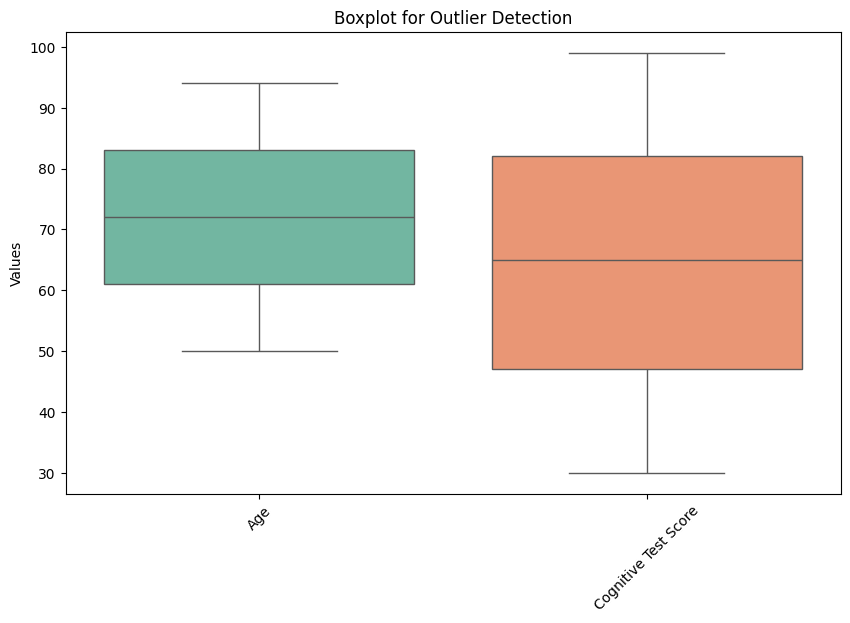

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
numerical_cols = ["Age", "Cognitive Test Score"]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_cols], palette="Set2")

plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.ylabel("Values")
plt.show()

### Correlation

In [26]:
correlation_matrix = df.corr()
target_correlation = correlation_matrix["Alzheimer’s Diagnosis"].sort_values(ascending=False)
print(target_correlation)

# Age                                         0.419923
# Genetic Risk Factor (APOE-ε4 allele)_Yes    0.194484
# Family History of Alzheimer’s_Yes           0.140885

Alzheimer’s Diagnosis                       1.000000
Age                                         0.419923
Genetic Risk Factor (APOE-ε4 allele)_Yes    0.194484
Family History of Alzheimer’s_Yes           0.140885
Country_Russia                              0.042795
Country_India                               0.042032
Country_South Africa                        0.038333
Country_Brazil                              0.034295
Country_Mexico                              0.032645
Income Level_Medium                         0.006950
Employment Status_Retired                   0.004721
Air Pollution Exposure_Low                  0.004571
Education Level                             0.003732
Smoking Status                              0.003690
Dietary Habits                              0.003239
Cholesterol Level_Normal                    0.002104
Social Engagement Level_Low                 0.002053
Alcohol Consumption                         0.001790
Gender_Male                                 0.

## Model

In [27]:
from scipy.stats import ttest_ind, chi2_contingency

# Alzheimer’s Diagnosis를 종속 변수(y)로 설정
y_col = "Alzheimer’s Diagnosis"
y = df[y_col]

# 독립 변수 설정
X = df.drop(columns=[y_col])

# 연속형 변수와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns
categorical_vars = [col for col in continuous_vars if df[col].nunique() <= 10]
continuous_vars = [col for col in continuous_vars if col not in categorical_vars]


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression

In [29]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_lr=accuracy_score(y_test, y_pred)
print("Accuracy:",acc_lr )
print(classification_report(y_test, y_pred))

Accuracy: 0.7108368857976217
              precision    recall  f1-score   support

           0       0.73      0.80      0.76     13065
           1       0.67      0.59      0.63      9220

    accuracy                           0.71     22285
   macro avg       0.70      0.69      0.70     22285
weighted avg       0.71      0.71      0.71     22285



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
acc_rf=accuracy_score(y_test, y_pred_rf)
print("🔹 Random Forest Classifier Results:")
print("Accuracy:",acc_rf )
print(classification_report(y_test, y_pred_rf))

🔹 Random Forest Classifier Results:
Accuracy: 0.7205743773838905
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     13065
           1       0.67      0.63      0.65      9220

    accuracy                           0.72     22285
   macro avg       0.71      0.71      0.71     22285
weighted avg       0.72      0.72      0.72     22285



### Decision Tree

In [31]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 5}
Accuracy: 0.7286066861117344
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     13065
           1       0.66      0.70      0.68      9220

    accuracy                           0.73     22285
   macro avg       0.72      0.72      0.72     22285
weighted avg       0.73      0.73      0.73     22285



### XGBoost

In [32]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:18:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classifier Results:
Accuracy: 0.7251963203948845
              precision    recall  f1-score   support

           0       0.77      0.76      0.76     13065
           1       0.66      0.68      0.67      9220

    accuracy                           0.73     22285
   macro avg       0.72      0.72      0.72     22285
weighted avg       0.73      0.73      0.73     22285



### LightGBM

In [33]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21493, number of negative: 30505
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 51998, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413343 -> initscore=-0.350163
[LightGBM] [Info] Start training from score -0.350163
🔹 LightGBM Model Performance 🔹
Accuracy: 0.7277092214494054
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     13065
           1       0.66      0.69      0.68      9220

    accuracy                           0.73     22285
   macro avg       0.72      0.72      0.72     22285
weighted avg       0.73      0.73      0.73     22285



### Catboost

In [34]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.7269912497195423
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     13065
           1       0.66      0.69      0.68      9220

    accuracy                           0.73     22285
   macro avg       0.72      0.72      0.72     22285
weighted avg       0.73      0.73      0.73     22285



# DL

In [35]:
df = pd.read_csv("alzheimers_prediction_dataset.csv")

In [36]:
# 분류 task
is_classification = True

In [37]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"Country" : categorical,
              "Age" : numerical,
              "Gender" : categorical,
              "Education Level" : numerical,
              "BMI" : numerical,
              "Physical Activity Level" : categorical,
              "Smoking Status" : categorical,
              "Alcohol Consumption" : categorical,
              "Diabetes" : categorical,
              "Hypertension" : categorical,
              "Cholesterol Level" : categorical,
              "Family History of Alzheimer’s" : categorical,
              "Cognitive Test Score" : numerical,
              "Depression Level" : categorical,
              "Sleep Quality" : categorical,
              "Dietary Habits" : categorical,
              "Air Pollution Exposure" : categorical,
              "Employment Status" : categorical,
              "Marital Status" : categorical,
              "Genetic Risk Factor (APOE-ε4 allele)" : categorical,
              "Social Engagement Level" : categorical,
              "Income Level" : categorical,
              "Stress Levels" : categorical,
              "Urban vs Rural Living" : categorical,
              "Alzheimer’s Diagnosis" : categorical
              }

dataset = Dataset(df = df, 
                  col_to_stype = col_to_stype, 
                  target_col = "Alzheimer’s Diagnosis")

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [38]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [39]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [40]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [41]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [42]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [43]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 175/175 [00:06<00:00, 27.63it/s] 


Train Loss: 0.6330, Train Acc: 0.7026, Val Acc: 0.7046, Test Acc: 0.7065


Epoch: 2: 100%|██████████| 175/175 [00:01<00:00, 109.67it/s]


Train Loss: 0.5574, Train Acc: 0.7126, Val Acc: 0.7057, Test Acc: 0.7156


Epoch: 3: 100%|██████████| 175/175 [00:01<00:00, 104.84it/s]


Train Loss: 0.5531, Train Acc: 0.7133, Val Acc: 0.7081, Test Acc: 0.7138


Epoch: 4: 100%|██████████| 175/175 [00:01<00:00, 126.83it/s]


Train Loss: 0.5463, Train Acc: 0.7133, Val Acc: 0.7088, Test Acc: 0.7178


Epoch: 5: 100%|██████████| 175/175 [00:01<00:00, 120.00it/s]


Train Loss: 0.5453, Train Acc: 0.7160, Val Acc: 0.7077, Test Acc: 0.7143


Epoch: 6: 100%|██████████| 175/175 [00:01<00:00, 123.79it/s]


Train Loss: 0.5416, Train Acc: 0.7221, Val Acc: 0.7142, Test Acc: 0.7210


Epoch: 7: 100%|██████████| 175/175 [00:01<00:00, 129.36it/s]


Train Loss: 0.5394, Train Acc: 0.7214, Val Acc: 0.7067, Test Acc: 0.7173


Epoch: 8: 100%|██████████| 175/175 [00:01<00:00, 128.21it/s]


Train Loss: 0.5369, Train Acc: 0.7251, Val Acc: 0.7134, Test Acc: 0.7188


Epoch: 9: 100%|██████████| 175/175 [00:01<00:00, 114.14it/s]


Train Loss: 0.5344, Train Acc: 0.7258, Val Acc: 0.7106, Test Acc: 0.7181


Epoch: 10: 100%|██████████| 175/175 [00:01<00:00, 148.89it/s]


Train Loss: 0.5319, Train Acc: 0.7288, Val Acc: 0.7170, Test Acc: 0.7201


Epoch: 11: 100%|██████████| 175/175 [00:01<00:00, 143.99it/s]


Train Loss: 0.5286, Train Acc: 0.7290, Val Acc: 0.7123, Test Acc: 0.7167


Epoch: 12: 100%|██████████| 175/175 [00:01<00:00, 112.38it/s]


Train Loss: 0.5273, Train Acc: 0.7278, Val Acc: 0.7112, Test Acc: 0.7137


Epoch: 13: 100%|██████████| 175/175 [00:01<00:00, 120.05it/s]


Train Loss: 0.5260, Train Acc: 0.7319, Val Acc: 0.7120, Test Acc: 0.7138


Epoch: 14: 100%|██████████| 175/175 [00:01<00:00, 124.59it/s]


Train Loss: 0.5235, Train Acc: 0.7367, Val Acc: 0.7167, Test Acc: 0.7188


Epoch: 15: 100%|██████████| 175/175 [00:01<00:00, 100.77it/s]


Train Loss: 0.5201, Train Acc: 0.7344, Val Acc: 0.7119, Test Acc: 0.7092
Best Val Acc: 0.7170, Best Test Acc: 0.7201


In [44]:
resnet_score = best_test_metric
resnet_score

0.720125645052726

### FT-T

In [45]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [46]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [47]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [48]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [49]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [50]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 175/175 [00:03<00:00, 46.63it/s]


Train Loss: 0.6661, Train Acc: 0.6302, Val Acc: 0.6329, Test Acc: 0.6377


Epoch: 2: 100%|██████████| 175/175 [00:03<00:00, 48.80it/s]


Train Loss: 0.6091, Train Acc: 0.7225, Val Acc: 0.7163, Test Acc: 0.7209


Epoch: 3: 100%|██████████| 175/175 [00:03<00:00, 51.95it/s]


Train Loss: 0.5531, Train Acc: 0.7233, Val Acc: 0.7174, Test Acc: 0.7221


Epoch: 4: 100%|██████████| 175/175 [00:03<00:00, 57.97it/s]


Train Loss: 0.5453, Train Acc: 0.7267, Val Acc: 0.7182, Test Acc: 0.7229


Epoch: 5: 100%|██████████| 175/175 [00:03<00:00, 51.14it/s]


Train Loss: 0.5410, Train Acc: 0.7255, Val Acc: 0.7192, Test Acc: 0.7196


Epoch: 6: 100%|██████████| 175/175 [00:04<00:00, 43.61it/s]


Train Loss: 0.5412, Train Acc: 0.7277, Val Acc: 0.7189, Test Acc: 0.7225


Epoch: 7: 100%|██████████| 175/175 [00:02<00:00, 59.14it/s]


Train Loss: 0.5384, Train Acc: 0.7255, Val Acc: 0.7180, Test Acc: 0.7212


Epoch: 8: 100%|██████████| 175/175 [00:03<00:00, 57.37it/s]


Train Loss: 0.5365, Train Acc: 0.7282, Val Acc: 0.7209, Test Acc: 0.7237


Epoch: 9: 100%|██████████| 175/175 [00:03<00:00, 57.46it/s]


Train Loss: 0.5347, Train Acc: 0.7291, Val Acc: 0.7194, Test Acc: 0.7229


Epoch: 10: 100%|██████████| 175/175 [00:03<00:00, 46.44it/s]


Train Loss: 0.5337, Train Acc: 0.7289, Val Acc: 0.7211, Test Acc: 0.7214


Epoch: 11: 100%|██████████| 175/175 [00:03<00:00, 47.46it/s]


Train Loss: 0.5328, Train Acc: 0.7299, Val Acc: 0.7180, Test Acc: 0.7211


Epoch: 12: 100%|██████████| 175/175 [00:03<00:00, 46.06it/s]


Train Loss: 0.5332, Train Acc: 0.7297, Val Acc: 0.7176, Test Acc: 0.7219


Epoch: 13: 100%|██████████| 175/175 [00:03<00:00, 53.73it/s]


Train Loss: 0.5322, Train Acc: 0.7302, Val Acc: 0.7196, Test Acc: 0.7208


Epoch: 14: 100%|██████████| 175/175 [00:03<00:00, 53.89it/s]


Train Loss: 0.5321, Train Acc: 0.7318, Val Acc: 0.7193, Test Acc: 0.7231


Epoch: 15: 100%|██████████| 175/175 [00:03<00:00, 56.09it/s]


Train Loss: 0.5299, Train Acc: 0.7287, Val Acc: 0.7181, Test Acc: 0.7204
Best Val Acc: 0.7211, Best Test Acc: 0.7214


In [51]:
ftt_score = best_test_metric
ftt_score

0.7213820955799866

### TabNet

In [52]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [53]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [54]:
# Set up model and optimizer
model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [55]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [56]:
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    lr_scheduler.step()

print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')

Epoch: 1: 100%|██████████| 175/175 [00:02<00:00, 59.30it/s]


Train Loss: 0.6108, Train Acc: 0.7101, Val Acc: 0.7060, Test Acc: 0.7085


Epoch: 2: 100%|██████████| 175/175 [00:02<00:00, 62.38it/s]


Train Loss: 0.5501, Train Acc: 0.7170, Val Acc: 0.7115, Test Acc: 0.7141


Epoch: 3: 100%|██████████| 175/175 [00:02<00:00, 69.40it/s]


Train Loss: 0.5407, Train Acc: 0.7216, Val Acc: 0.7135, Test Acc: 0.7158


Epoch: 4: 100%|██████████| 175/175 [00:02<00:00, 69.25it/s]


Train Loss: 0.5341, Train Acc: 0.7228, Val Acc: 0.7119, Test Acc: 0.7153


Epoch: 5: 100%|██████████| 175/175 [00:03<00:00, 57.94it/s]


Train Loss: 0.5291, Train Acc: 0.7234, Val Acc: 0.7110, Test Acc: 0.7143


Epoch: 6: 100%|██████████| 175/175 [00:02<00:00, 63.44it/s]


Train Loss: 0.5247, Train Acc: 0.7283, Val Acc: 0.7111, Test Acc: 0.7162


Epoch: 7: 100%|██████████| 175/175 [00:03<00:00, 53.40it/s]


Train Loss: 0.5208, Train Acc: 0.7307, Val Acc: 0.7108, Test Acc: 0.7117


Epoch: 8: 100%|██████████| 175/175 [00:02<00:00, 76.09it/s]


Train Loss: 0.5136, Train Acc: 0.7361, Val Acc: 0.7126, Test Acc: 0.7116


Epoch: 9: 100%|██████████| 175/175 [00:03<00:00, 53.93it/s]


Train Loss: 0.5086, Train Acc: 0.7389, Val Acc: 0.7061, Test Acc: 0.7104


Epoch: 10: 100%|██████████| 175/175 [00:02<00:00, 69.04it/s]


Train Loss: 0.5028, Train Acc: 0.7418, Val Acc: 0.7044, Test Acc: 0.7083


Epoch: 11: 100%|██████████| 175/175 [00:02<00:00, 68.33it/s]


Train Loss: 0.4971, Train Acc: 0.7462, Val Acc: 0.7052, Test Acc: 0.7068


Epoch: 12: 100%|██████████| 175/175 [00:02<00:00, 68.02it/s]


Train Loss: 0.4916, Train Acc: 0.7494, Val Acc: 0.7052, Test Acc: 0.7051


Epoch: 13: 100%|██████████| 175/175 [00:02<00:00, 64.11it/s]


Train Loss: 0.4869, Train Acc: 0.7525, Val Acc: 0.7048, Test Acc: 0.7051


Epoch: 14: 100%|██████████| 175/175 [00:02<00:00, 70.78it/s]


Train Loss: 0.4803, Train Acc: 0.7572, Val Acc: 0.7032, Test Acc: 0.7040


Epoch: 15: 100%|██████████| 175/175 [00:02<00:00, 65.22it/s]


Train Loss: 0.4760, Train Acc: 0.7616, Val Acc: 0.6961, Test Acc: 0.7014
Best Val Acc: 0.7135, Best Test Acc: 0.7158


In [57]:
tabnet_score = best_test_acc
tabnet_score

0.7157729414404308

### Tab_Transformer

In [58]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [59]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [60]:
# Set up model and optimizer
model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [61]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [62]:
metric = 'ACC'
best_val_metric = 0
best_test_metric = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
    lr_scheduler.step()

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')

Epoch: 1: 100%|██████████| 175/175 [00:12<00:00, 13.90it/s]


Train Loss: 1.0723, Train ACC: 0.6481, Val ACC: 0.6455, Test ACC: 0.6547


Epoch: 2: 100%|██████████| 175/175 [00:12<00:00, 14.38it/s]


Train Loss: 0.6244, Train ACC: 0.6733, Val ACC: 0.6718, Test ACC: 0.6748


Epoch: 3: 100%|██████████| 175/175 [00:12<00:00, 14.34it/s]


Train Loss: 0.6260, Train ACC: 0.6536, Val ACC: 0.6436, Test ACC: 0.6523


Epoch: 4: 100%|██████████| 175/175 [00:12<00:00, 14.38it/s]


Train Loss: 0.6156, Train ACC: 0.6665, Val ACC: 0.6616, Test ACC: 0.6692


Epoch: 5: 100%|██████████| 175/175 [00:12<00:00, 14.21it/s]


Train Loss: 0.6154, Train ACC: 0.6647, Val ACC: 0.6558, Test ACC: 0.6668


Epoch: 6: 100%|██████████| 175/175 [00:12<00:00, 14.26it/s]


Train Loss: 0.6093, Train ACC: 0.6689, Val ACC: 0.6656, Test ACC: 0.6744


Epoch: 7: 100%|██████████| 175/175 [00:12<00:00, 14.45it/s]


Train Loss: 0.6095, Train ACC: 0.6734, Val ACC: 0.6679, Test ACC: 0.6728


Epoch: 8: 100%|██████████| 175/175 [00:12<00:00, 14.39it/s]


Train Loss: 0.6020, Train ACC: 0.6737, Val ACC: 0.6655, Test ACC: 0.6763


Epoch: 9: 100%|██████████| 175/175 [00:12<00:00, 14.26it/s]


Train Loss: 0.5995, Train ACC: 0.6695, Val ACC: 0.6645, Test ACC: 0.6716


Epoch: 10: 100%|██████████| 175/175 [00:12<00:00, 14.21it/s]


Train Loss: 0.5988, Train ACC: 0.6680, Val ACC: 0.6630, Test ACC: 0.6700


Epoch: 11: 100%|██████████| 175/175 [00:12<00:00, 14.46it/s]


Train Loss: 0.5962, Train ACC: 0.6834, Val ACC: 0.6741, Test ACC: 0.6854


Epoch: 12: 100%|██████████| 175/175 [00:12<00:00, 14.47it/s]


Train Loss: 0.5935, Train ACC: 0.6706, Val ACC: 0.6663, Test ACC: 0.6758


Epoch: 13: 100%|██████████| 175/175 [00:12<00:00, 14.46it/s]


Train Loss: 0.5903, Train ACC: 0.6760, Val ACC: 0.6710, Test ACC: 0.6682


Epoch: 14: 100%|██████████| 175/175 [00:12<00:00, 14.43it/s]


Train Loss: 0.5915, Train ACC: 0.6739, Val ACC: 0.6686, Test ACC: 0.6785


Epoch: 15: 100%|██████████| 175/175 [00:12<00:00, 14.48it/s]


Train Loss: 0.5909, Train ACC: 0.6820, Val ACC: 0.6793, Test ACC: 0.6816
Best Val ACC: 0.6793, Best Test ACC: 0.6816


In [63]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.6816244110388153

# 시각화

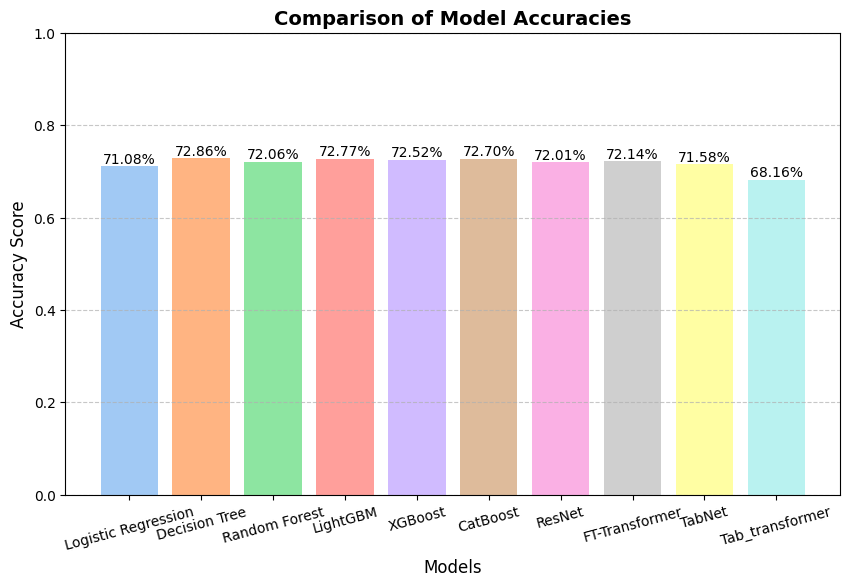

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [acc_lr, acc_dt, acc_rf, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()